## FASE II: DATA UNDERSTANTING

* Estudio y comprension de los datos

Esta fase comprende la recoleccion de los datos, como todos los pasos para familiarizarse con estos, desde identificar los problemas de los datos hasta descubrir subconjuntos de informacion importantes

### RECOLECCION DE DATOS

* Diagrama de recoleccion y organizacion de fuentes de datos

![](ResourcesMedia/IMAGEN_Diagrama_recoleccion_integracion_datos.png)

##### DESCRIPCION DE FUENTES DE DATOS

* La recoleccion de datos es un paso crucial para la ciencia de datos debido a que los modelos predictivos usan datos para poder entrenarse y hacer predicciones.

* Entre las fuentes de datos tenemos 3 distintas que enumeraremos a continuacion:

    1. **Datos de pneumonia en la plataforma Kaggle [[Link]](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)**: Este posee los set de datos de radiografias panoramicas reales de los individuos que se categorizan en dos Casos, la primera donde se observan neumonias(distintas al COVID19) y la segunda casos normales.
    2. **Datos de la plataforma BIMCV-COVID19** [[Link]](https://b2drop.bsc.es/index.php/s/BIMCV-COVID19): Esta fuente es importante porque nos porporciona los datos de los pacientes con radiografias de covid19 positivas, como tambien negativas. De este dataset solo extraeremos los datos de los casos positivos para complementarlos con la fuente de Kaggle.
    3. **Datos de github ieee8023/ Radiografias covid** [[Link]](https://github.com/ieee8023/covid-chestxray-dataset): Esta fuente posee casos de disitintas neumonias como tambien covid19, por lo que nos servira para evaluar el rendimiento del modelo con estos datos. Estos datos se separan para las pruebas.

##### ENTENDIENDO LOS DATOS DE KAGGLE

* Los datos de kaggle descargados pesan aproximadamante 1.7GB, y si descubrimos el interior de sus carpetas estas poseen subdirectorios ya divididos previamente.

![tree](ResourcesMedia/tree_kaggle.png)

Estos son subconjuntos de Test, Train, y validacion ya divididos por la plataforma. Ac ontinuacion veremos cual es la proporcion de dichas clases tanto de NORMAL y NEUMONIA en todas los directorios

In [41]:
import os
import pandas as pd
#deglosar los problemas en otros mas pequeños.
def count_files(source): #cuenta el numero de archivos en un directorio
    return len([arch.name for arch in os.scandir(source) if arch.is_file()])

#escanea los directorios
def scan_directories(source):
    count=0
    info=dict()
    for (f_path,f_name) in [(arch.path, arch.name)for arch in os.scandir(source) if arch.is_dir()]:
        info[f_name]=dict()
        for (second_path,second_name) in [(arch.path, arch.name) for arch in os.scandir(f_path) if arch.is_dir()]:
            info[f_name][second_name]=count_files(second_path)
    return info

In [58]:
report=scan_directories("../Datasets/KAGGLE_chest_xray")
report_frame=pd.DataFrame(report)

La proporcion de datos mayoritaria la tiene el train, seguido de test, y val. Entonces averiguemos la proporcion de datos

In [60]:
report_frame.sum(axis=1)

NORMAL       1583
PNEUMONIA    4273
dtype: int64

In [62]:
report_frame.sum(axis=0).to_frame()*100/report_frame.sum(axis=0).sum()

,0
test,10.655738
train,89.071038
val,0.273224


Se observa que el conjunto de train posee el 90% de datos. El de Test 10% de los datos y el de validacion 0.27%

* Por lo tanto seria bueno, que al juntar los datos de las 3 fuentes, volvamos a equilibrar dichos datos
* Ahora experimientemos con una imagen de casos normales vs una de casos de pneumonia

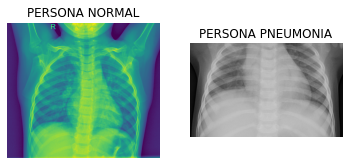

In [75]:
import matplotlib.pyplot as plt

fig,axes=plt.subplots(1,2)
img_norm=plt.imread(r"..\Datasets\KAGGLE_chest_xray\train\NORMAL\IM-0115-0001.JPEG")
axes[0].imshow(img_norm,cmap="viridis")
axes[0].axis(False)
axes[0].set_title("PERSONA NORMAL")
img_pneumonia=plt.imread(r"..\Datasets\KAGGLE_chest_xray\train\PNEUMONIA\person1_bacteria_1.JPEG")
axes[1].imshow(img_pneumonia,cmap="bone")
axes[1].axis(False)
axes[1].set_title("PERSONA PNEUMONIA")
plt.show()

Podemos notar tambien que inspeccionando los datos, la imagenes varian de tamaño (height,width), como que  se encuentran en buena calidad

##### ENTENDIENDO LOS DATOS DEL BIMCV COVID-19

* Los datos del BIMCV Version 1 pesan aproximadamente 70GB. Por lo cual en un inicio no pude descargar todo. Pero si una pequeñas muestra. A continuacion mostrare una de estas, puesto que pertenece a pulmones con COVID19

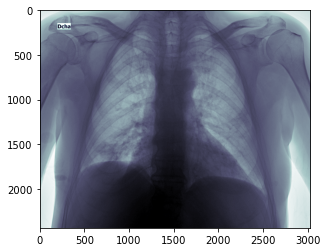

In [77]:
img_covid=plt.imread(r"..\Datasets\BIMCV_covid19\sub-S03045_ses-E06139_run-1_bp-chest_vp-ap_dx.png")
plt.imshow(img_covid,cmap="bone")

##### SCRIPT de Compresion de tamaño

* Ahora bien, una de las maneras de tratar con datos muy extensos en cambiando su tamaño para poder tratarlos. Por lo tanto lo que se hara es iterar sobre cada carpeta que contienen los datos de esta radiografia en la fuente de la pagina BIMCV, luego cada carpeta se descomprime, y se itera cada imagen  que cumpla con un **criterio de calidad**, y se cambia el tamaño y calidad a unade menor proporcion. Una vez que las imagenes hayan sido procesadas, entonces se elimina la carpeta descargada porque ocupa espacio, y seguimos el mismo porceso con la siguiente carpeta de la fuente.
* Se espera que el conjunto de datos BIMCV pase de 70GB a menos de 3GB de informacion

##### Documentacion del conjunto de datos de la primera version de radiografias BIMCV COVID19

* Adjunto a dichas imagenes se encuentra una documentacion de cada imagen asociada para saber la informacion de:
    * **Sujeto de prueba**
    * **Numero de la sesion** cuando se hizo la radiografia
    * **Excluido**: Parametro en la documentacion que indica si la imagen fue excluida por mala calidad de datos o praxis al tomar la radiografia. Este va a ser el parametro determinante para cumplir con el **criterio de calidad** puesto que si la imagen esta excluida o no posee etiqueta de exclusion, entonces no se procesara y no ira al set de datos de entrenamiento.
    * **Position_manual**: Indica cual fue la posicion cuando se tomo la radiografia. Puede ser L(Lateral) y PA (Panoramica), esta caracteristica en importante debido a que seleccionare aquellas con vista **PA**noramica porque el resto de set de datos de kaggle como de github tambien usan esta posicion de rediografia. Esta tambien sera importante para el filtro de imagenes.
        

In [82]:
documentacion=pd.read_excel(r"..\Info\COVID19_POSI_v1.0.xlsx",skiprows=1)

In [83]:
documentacion.head()

,Subject,Session,mod,File,Type,Position_Manual,Exclude,Exclude Reason,Labels,Localizations,...,Total Collimation Width,Contrast/Bolus Total Dose,Detector Type,Imager Pixel Spacing,Exposure Index,Filter Thickness Maximum,Performed Procedure Step Start Time,Bits Stored,Study Instance UID,Patient Gantry Relationship Code Sequence
0,sub-S03427,ses-E06828,mod-rx,sub-S03427_ses-E06828_acq-2_run-1_bp-chest_vp-...,dx,L,False,NaN,normal,"loc right', 'loc basal",...,NaN,NaN,SCINTILLATOR,"0.194556, 0.194556",NaN,NaN,120155.000,14,1.2.840.113654.2.70.1.309068113975663760947917...,"{'00080100': {'Value': F-10470, 'vr': 'SH'}, '..."
1,sub-S03427,ses-E06828,mod-rx,sub-S03427_ses-E06828_acq-1_run-1_bp-chest_vp-...,dx,PA,False,NaN,normal,"loc right', 'loc basal",...,NaN,NaN,SCINTILLATOR,"0.194556, 0.194556",NaN,NaN,120155.000,14,1.2.840.113654.2.70.1.309068113975663760947917...,"{'00080100': {'Value': F-10470, 'vr': 'SH'}, '..."
2,sub-S03809,ses-E08956,mod-rx,sub-S03809_ses-E08956_run-1_bp-chest_vp-pa_cr.png,cr,PA,False,NaN,"', 'aortic elongation', 'apical pleural thicke...","loc pleural', 'loc apical', 'loc aortic",...,NaN,NaN,NaN,"0.143, 0.143",NaN,NaN,54533.171,12,1.2.840.113654.2.70.1.186511615104268000178363...,NaN
3,sub-S03809,ses-E08956,mod-rx,sub-S03809_ses-E08956_run-1_bp-chest_vp-ll_cr.png,cr,L,False,NaN,"', 'aortic elongation', 'apical pleural thicke...","loc pleural', 'loc apical', 'loc aortic",...,NaN,NaN,NaN,"0.143, 0.143",NaN,NaN,54533.171,12,1.2.840.113654.2.70.1.186511615104268000178363...,NaN
4,sub-S03815,ses-E07684,mod-rx,sub-S03815_ses-E07684_run-1_bp-chest_vp-pa_cr.png,cr,PA,False,NaN,"cardiomegaly', ' mediastinal enlargement","loc cardiac', 'loc pleural', 'loc hilar', 'loc...",...,NaN,NaN,NaN,"0.1, 0.1",NaN,NaN,NaN,12,1.2.840.113654.2.70.1.265152392180858666702237...,NaN


In [84]:
documentacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5525 entries, 0 to 5524
Columns: 261 entries, Subject to Patient Gantry Relationship Code Sequence
dtypes: bool(1), float64(114), int64(12), object(134)
memory usage: 11.0+ MB


La informacion nos dice que la documentacion posee 5525 entradas de imagenes covid, y 261 columnas.

Entonces veamos cual es la cantidad de sujetos a los que se les obtuvo un resutado de covid positivo

In [93]:
print(f"cantidad de Sujetos COVID {len(documentacion.groupby('Subject'))}")

cantidad de Sujetos COVID 1310


Veamos la proporcion de posiciones manuales de radioagrafias

In [97]:
documentacion.Position_Manual.value_counts(normalize=True).map(lambda x: f"{x*100:.3f}%")

PA    74.795%
L     25.205%
Name: Position_Manual, dtype: object

<AxesSubplot:ylabel='Position_Manual'>

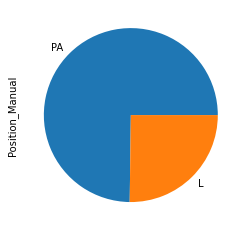

In [102]:
documentacion.Position_Manual.value_counts(normalize=True).plot(kind="pie")

Esto significa que aproximadamente el 25% de los sujetos fueron tomados con radiografia LATERAL, esta porcion no se tomara en cuenta para el modelo.

* Ahora vemos la proporcion de radiografias que salieron excluidas por mala calidad

In [100]:
documentacion.Exclude.value_counts(normalize=True).map(lambda x: f"{x*100:.3f}%")

False    99.783%
True      0.217%
Name: Exclude, dtype: object

<AxesSubplot:ylabel='Exclude'>

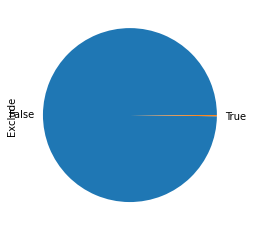

In [101]:
documentacion.Exclude.value_counts(normalize=True).plot(kind="pie")

La pequeña proporcion de datos se eliminara por tener mala calidad en todos los sets de datos.

Ahora estimaremos, cual seria la cantidad de radiografias que quedarian luego de aplicar los filtros de posicion y exclusion.

In [106]:
mask_entry=(documentacion.Position_Manual=="PA") | (documentacion.Exclude==False)
mask_entry.sum() #cantidad de muestras que radioagrafias que seran procesadas. Estimacion

5525

In [121]:
#genero la tabla de filtros para las imagenes
documentacion[["File","Position_Manual","Exclude"]].to_csv("tabla_filtros.csv",index=False)

#### IMPORTANTE: Sobre la obtencion y optimizacion de datos de BIMCV COVID19

* En la raiz del directorio de este proyecto, se creo un Script que comprime las imagenes de las radiografias covid conservando su calidad y disminuyendo su peso. El script llamado **script_compressor.py** toma una carpeta como entrada **source** y busca todas las imagenes que pueda encontrar en su interior para comprimirlas y guardarlas en un directorio de salida especificado por **dest**. Asi que para dterminar que imagenes comprimir o no, hace uso de la **tabla de filtro** generada en este notebook **tabla_filtros.csv** que posee informacion sobre las radiografias que fueron detalladas por expertos. El criterio de filtro ya fue explicado anteriormente. 

* Una vez ejecutado el script,  las imagenes se generaron en el directorio del proyecto **Datasets/BIMCV-COVID19** donde tambien se encuentran los datos de kaggle.
* **ojo**: En mi caso decidi descargar carpeta por carpeta de la fuente de datos por temas de ahorro de espacio en disco, asi que luego de terminar su escaneo y compresion, descargaba otra y asi consecutivamente. Esto es porque al fuente de datos posee la opcion de *descargar todo* o de *seleccionar que carpeta descargar*.

### ENTENDIENDO LOS DATOS DE github ieee8023/ Radiografias covid

* El proposito del repositorio

Construir un conjunto de datos abierto público de imágenes de rayos X de tórax y TC de pacientes que son positivos o sospechosos de COVID-19 u otras neumonías virales y bacterianas(MERS, SARSy SDRA). Los datos se recopilarán de fuentes públicas, así como a través de la recopilación indirecta de hospitales y médicos. Todas las imágenes y datos se publicarán públicamente en este repositorio de GitHub.All images and data will be released publicly in this GitHub repo.

Este proyecto está aprobado por el Comité de Ética de la Universidad de Montreal #CERSES-20-058-D